In [ ]:
import sys
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import pandas as pd
from helpers import *
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOauthError
import spotipy.oauth2 as oauth2
from sklearn import preprocessing


In [ ]:

cid = "bc13d66ac4bf4702ac2bac333552a7d6"
secret = "361b64012a7843128a06fec17e89af08"
spotifyId = "06AKEBrKUckW0KREUWRnvT"

try:
    client_credentials_manager = SpotifyClientCredentials(
        client_id=cid,
        client_secret=secret )
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

except SpotifyOauthError:
    print("Spotipy credentials not found.")



In [ ]:
def get_features(tracks):
    allTrackFeatures = []
    for _,album in enumerate(tracks):
        for _, name in enumerate(tracks[album]):
            trackFeatures = sp.audio_features(tracks[album][name])[0]
            
            trackInformation = sp.track(tracks[album][name])
            trackFeatures['popularity'] = trackInformation['popularity']
            trackFeatures['track_number'] = trackInformation['track_number']
            trackFeatures['duration_ms'] = trackInformation['duration_ms']
            trackFeatures['album'] = album
            trackFeatures['track'] = name
            allTrackFeatures.append(trackFeatures)

    return pd.DataFrame(allTrackFeatures)


def get_album_tracks(albumId):
    tracks = {}
    batch_size = 10
    
    offset = 0
    while True:
        new_tracks = sp.album_tracks(albumId, limit=batch_size, offset=offset)["items"]
        for i in range(len(new_tracks)):
            
            tracks[new_tracks[i]['name']] = new_tracks[i]['id']
        if not len(new_tracks):
            break        
        offset += batch_size
    return tracks


In [ ]:
# welke key levert het meeste geld op.
# Welke key maakt het genre?

def collect_all_tracks(query, t):
    N = 10
    search_result = sp.search(query, N, 0, t)
    albumsNames = []
    tracks = []
    Alltracks = {}
    for i in range(N):
        artist = search_result['albums']['items'][i]['artists'][0]['name']
        if artist == query:
            album = search_result['albums']['items'][i]['name']
            Alltracks[album] = get_album_tracks(search_result['albums']['items'][i]['id'])
    return Alltracks

Alltracks = collect_all_tracks('Daft Punk', 'album')



In [35]:
def cleanData(Alltracks):
    Audiofeatures = get_features(Alltracks)
    Audiofeatures = Audiofeatures.drop(['analysis_url','track_href','type','uri'],axis=1)

    keyDict = {0:'c',1:'c#',2:'d',3:'d#',4:'e',5:'f',6:'f#',7:'g',8:'g#',9:'a',10:'a#',11:'b'}
    modeDict = {0:'minor',1:'major'}
    Audiofeatures[['key','mode']] = Audiofeatures[['key','mode']].replace({'key':keyDict, 'mode':modeDict})

    # # Audiofeatures2.groupby(['key','mode']).size().reset_index().rename(columns={0:'count'})
    Audiofeatures["TonalQuality"] = Audiofeatures["key"]+" " + Audiofeatures["mode"]
    Audiofeatures = Audiofeatures.drop(['key','mode'],axis=1)
    return Audiofeatures
Audiofeatures = cleanData(Alltracks)

# Audiofeatures.groupby('TonalQuality')['id'].count()



retrying ...5secs
retrying ...4secs
     acousticness                      album  danceability  duration_ms  \
0        0.002860     Random Access Memories         0.788       275386   
1        0.825000     Random Access Memories         0.712       322146   
2        0.069200     Random Access Memories         0.740       544626   
3        0.894000     Random Access Memories         0.702       228506   
4        0.042200     Random Access Memories         0.775       337560   
5        0.083900     Random Access Memories         0.832       353893   
6        0.477000     Random Access Memories         0.290       498960   
7        0.037800     Random Access Memories         0.810       369626   
8        0.367000     Random Access Memories         0.716       290240   
9        0.512000     Random Access Memories         0.548       341653   
10       0.041000     Random Access Memories         0.807       279773   
11       0.388000     Random Access Memories         0.804      

In [57]:
def AllTracksArtist(names):
    trackDict = {}
    for artist in names:
        trackDict[artist]=cleanData(collect_all_tracks(artist, 'album'))
    
    return trackDict
alltracks = AllTracksArtist(['Daft Punk', "Kanye West"])
# Audiofeatures.groupby('TonalQuality')['popularity'].value_counts()
# 

retrying ...4secs
retrying ...6secs
retrying ...6secs


Index(['acousticness', 'album', 'danceability', 'duration_ms', 'energy', 'id',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo', 'time_signature', 'track', 'track_number', 'valence',
       'TonalQuality'],
      dtype='object')


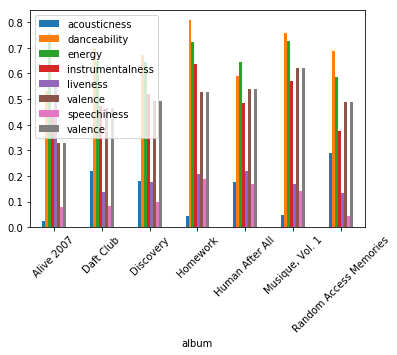

In [56]:
print(alltracks[artist].keys())
MeanPerAlbum = {}
for artist in alltracks:
    MeanPerAlbum[artist]= alltracks[artist].groupby('album')['acousticness','danceability','energy','instrumentalness','liveness','valence','speechiness','valence'].mean() 


MeanPerAlbum['Daft Punk'] = MeanPerAlbum['Daft Punk'].drop(['TRON: Legacy Reconfigured', 'TRON: Legacy','Get Lucky (feat. Pharrell Williams & Nile Rodgers) [Radio Edit]'])
dfMeanPerAlbum = pd.DataFrame(MeanPerAlbum['Daft Punk'])


# x = dfMeanPerAlbum.values 
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# dfMeanPerAlbumNormalised = pd.DataFrame(x_scaled)

ax = dfMeanPerAlbum.plot.bar(rot=0)
f = ax.set_xticklabels(dfMeanPerAlbum.index,rotation=45)




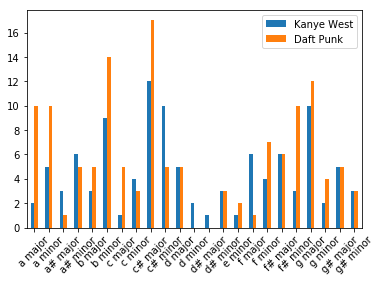

In [18]:
# alltracks.keys()
def MostPopulairKey():
    tonalQuality = {}
    val = {}

    for artist in alltracks:
        tonalQuality[artist] = dict(alltracks[artist]['TonalQuality'].value_counts())
    tone = pd.DataFrame(tonalQuality)
    keys = tone.index
    kanye =tone['Kanye West']
    daft = tone['Daft Punk']

    df = pd.DataFrame({'Kanye West':kanye,
                        "Daft Punk":daft},
                        index = keys)
    ax = df.plot.bar(rot=0)
    f = ax.set_xticklabels(df.index,rotation=45)

MostPopulairKey()

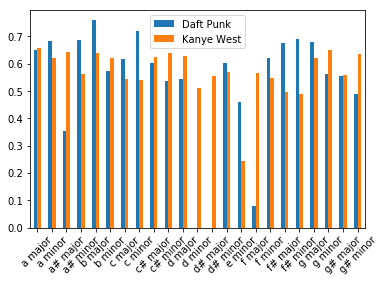

In [27]:
danceability = {}
for artist in alltracks:
    danceability[artist] = alltracks[artist].groupby('TonalQuality')['danceability'].mean()
    
dance = pd.DataFrame(danceability).fillna(0)
ax = dance.plot.bar(rot=0)

ax = ax.set_xticklabels(dance.index,rotation=45)




In [22]:

def get_playlist_tracks(query,t):
    N = 1
    search_result = sp.search(query, 10, 0, t)

    playlist = search_result['playlists']['items'][0]['id']
    
    tracks = []
    batch_size = 100
    
    offset = 0
    while True:
        new_tracks = sp.playlist_tracks(playlist, limit=batch_size, offset=offset)["items"]
        if not len(new_tracks):
            break
        tracks += [t["track"] for t in new_tracks]
        offset += batch_size
    return tracks

top2000 = get_playlist_tracks('Top 2000', 'playlist')



In [60]:

def top2000clean(top2000):
    top2000Features = []
    for i,v in enumerate(top2000):
        trackdata = {}
        trackId = top2000[i]['id']
        trackdata = sp.audio_features(trackId)[0]    
        trackdata['id'] = trackId
        trackdata['artists'] = top2000[i]['artists']
        trackdata['popularity'] = top2000[i]['popularity']
        trackdata['name'] = top2000[i]['name']
        top2000Features.append(trackdata)
    return pd.DataFrame(top2000Features)
top2000Features = top2000clean(top2000)    

retrying ...7secs
retrying ...6secs
retrying ...6secs
retrying ...7secs
retrying ...5secs
retrying ...7secs
retrying ...6secs
retrying ...6secs
retrying ...5secs
retrying ...5secs
retrying ...7secs
retrying ...5secs
retrying ...6secs
retrying ...7secs
retrying ...3secs


In [61]:

top2000Features = top2000Features.drop(['analysis_url','track_href','type','uri'],axis=1)


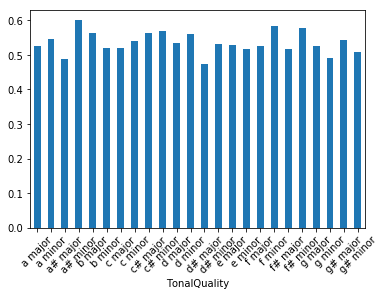

In [62]:
keyDict = {0:'c',1:'c#',2:'d',3:'d#',4:'e',5:'f',6:'f#',7:'g',8:'g#',9:'a',10:'a#',11:'b'}
modeDict = {0:'minor',1:'major'}
top2000Features[['key','mode']] = top2000Features[['key','mode']].replace({'key':keyDict, 'mode':modeDict})

top2000Features["TonalQuality"] = top2000Features["key"]+" " + top2000Features["mode"]
top2000Features = top2000Features.drop(['key','mode'],axis=1)
dancabilityKey = top2000Features.groupby('TonalQuality')['danceability'].mean()

plt.figure()
ax = dancabilityKey.plot.bar(rot=0)
ax = ax.set_xticklabels(dancabilityKey.index,rotation=45)

# danceability[artist] = alltracks[artist].groupby('TonalQuality')['danceability'].mean()

# top2000Overtime.plot(top2000Overtime)
